In [6]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Data import CodonTable
import os

def read_gene_expression(file_path):
    """
    Read gene expression data with RNA-Seq RSEM normalized values

    Parameters:
    file_path (str): Path to gene expression file

    Returns:
    pandas.DataFrame: DataFrame with patient_id, sample_id and gene expression values
    """
    # Read the tab-separated file
    df = pd.read_csv(file_path, sep='\t')
    print(f"Gene expression data loaded: {df.shape[0]} samples, {df.shape[1]-2} genes")
    return df

def read_somatic_mutations(file_path):
    """
    Read somatic mutations data in MAF format

    Parameters:
    file_path (str): Path to mutation annotation file
    2`x
    Returns:
    pandas.DataFrame: DataFrame with mutation information
    """
    # Read the tab-separated MAF file
    df = pd.read_csv(file_path, sep='\t')
    print(f"Somatic mutations data loaded: {df.shape[0]} mutations")
    return df

def read_patient_metadata(file_path):
    """
    Read patient clinical and pathological metadata

    Parameters:
    file_path (str): Path to patient metadata file

    Returns:
    pandas.DataFrame: DataFrame with patient clinical information
    """
    # Read the tab-separated metadata file
    df = pd.read_csv(file_path, sep='\t')
    print(f"Patient metadata loaded: {df.shape[0]} patients")
    return df

def explore_data(gene_expr, somatic_mut, patient_meta):
    """
    Basic exploration of the three datasets
    """
    # Explore patient metadata
    print("\nPatient demographics:")
    print(f"Gender distribution:\n{patient_meta['gender'].value_counts()}")
    print(f"Age statistics:\n{patient_meta['age_at_initial_pathologic_diagnosis'].describe()}")

    # Analyze survival data
    print("\nSurvival statistics:")
    print(f"Overall survival events: {patient_meta['OS'].sum()} deaths out of {patient_meta['OS'].count()} patients")

    # Look at mutations per patient
    if 'patient_id' in somatic_mut.columns:
        mutations_per_patient = somatic_mut['patient_id'].value_counts()
        print(f"\nMutations per patient statistics:")
        print(mutations_per_patient.describe())

    # For gene expression, we could look at the most variable genes
    if gene_expr is not None and gene_expr.shape[1] > 2:
        print("\nGene expression statistics:")
        gene_columns = gene_expr.columns[2:]  # Skipping patient_id and sample_id
        gene_variance = gene_expr[gene_columns].var().sort_values(ascending=False)
        print(f"Top 5 most variable genes:\n{gene_variance.head(5)}")

# 假设你的文件路径
gene_expression_path = os.path.join(os.getcwd(), 'Team_4_STAD', 'TCGA.STAD.expression.txt')
somatic_mutations_path = os.path.join(os.getcwd(), 'Team_4_STAD', 'TCGA.STAD.mutations.txt')
metadata_path = os.path.join(os.getcwd(),'Team_4_STAD', 'TCGA.STAD.metadata.txt')

# 读取三个数据集
gene_expr = read_gene_expression(gene_expression_path)
somatic_mut = read_somatic_mutations(somatic_mutations_path)
patient_meta = read_patient_metadata(metadata_path)

# 探索数据
explore_data(gene_expr, somatic_mut, patient_meta)

Gene expression data loaded: 447 samples, 20531 genes
Somatic mutations data loaded: 234941 mutations
Patient metadata loaded: 415 patients

Patient demographics:
Gender distribution:
gender
MALE      265
FEMALE    150
Name: count, dtype: int64
Age statistics:
count    410.000000
mean      65.787805
std       10.746983
min       30.000000
25%       58.000000
50%       67.000000
75%       73.000000
max       90.000000
Name: age_at_initial_pathologic_diagnosis, dtype: float64

Survival statistics:
Overall survival events: 160.0 deaths out of 415 patients

Mutations per patient statistics:
count      415.000000
mean       566.122892
std       1163.583650
min          1.000000
25%        108.000000
50%        173.000000
75%        383.000000
max      14110.000000
Name: count, dtype: float64

Gene expression statistics:
Top 5 most variable genes:
ADAM6|8755     1.094407e+11
KRT4|3851      4.444138e+10
KRT13|3860     3.805078e+10
PGC|5225       2.561217e+10
PGA3|643834    1.474750e+10
dtype:

In [7]:
# 2）查看缺失与基本统计
print(patient_meta.info())
print(somatic_mut[['Hugo_Symbol','Variant_Classification']].value_counts())

# 3）必要的清洗示例：去除无基因名或无坐标的行
muts = somatic_mut.dropna(subset=["Hugo_Symbol","Chromosome","Start_Position"])
meta = patient_meta.dropna(subset=["patient_id"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   patient_id                           415 non-null    object 
 1   type                                 415 non-null    object 
 2   age_at_initial_pathologic_diagnosis  410 non-null    float64
 3   gender                               415 non-null    object 
 4   race                                 415 non-null    object 
 5   ajcc_pathologic_tumor_stage          415 non-null    object 
 6   histological_type                    415 non-null    object 
 7   histological_grade                   415 non-null    object 
 8   tumor_status                         373 non-null    object 
 9   vital_status                         415 non-null    object 
 10  OS                                   415 non-null    float64
 11  OS.time                         

In [8]:
# 定义哪些分类算「同义」、哪些算「非同义」
synonymous = {
    "Silent",
    "Intron",           # 可根据需要扩展
    "IGR",              # Intergenic
    "RNA"               # 非编码 RNA 区
}
nonsynonymous = {
    "Missense_Mutation",
    "Nonsense_Mutation",
    "Splice_Site",
    "Frame_Shift_Del",
    "Frame_Shift_Ins",
    "Translation_Start_Site",
}

# 标记
def classify(row):
    if row["Variant_Classification"] in synonymous:
        return False  # 同义
    elif row["Variant_Classification"] in nonsynonymous:
        return True   # 非同义
    else:
        return None   # 无法归类时设为 None

muts["is_nonsynonymous"] = muts.apply(classify, axis=1)
# 丢弃无法分类的行
muts = muts.dropna(subset=["is_nonsynonymous"])

In [9]:
# 强制转换为 pandas 的 BooleanDtype
muts["is_nonsynonymous"] = muts["is_nonsynonymous"].astype("boolean")

# 这时 ~ 是逻辑取反
dnds = (
    muts
    .groupby("Hugo_Symbol")["is_nonsynonymous"]
    .agg(
        dN = "sum",             # True 当作 1
        dS = lambda s: (~s).sum()  # False 当作 1
    )
    .reset_index()
)
dnds["dN/dS"] = dnds["dN"] / (dnds["dS"] + 1e-6)

# filter out dS == 0
dnds = dnds[dnds["dS"] != 0]

# filter out dN/dS > 100
dnds = dnds[dnds["dN/dS"] < 100]
dnds.sort_values("dN/dS", ascending=False, inplace=True)

print(dnds.head(20))

      Hugo_Symbol  dN  dS      dN/dS
273        ACVR2A  52   1  51.999948
11672        PGM5  34   1  33.999966
12945       RASA1  33   1  32.999967
6428       GRIN3A  29   1  28.999971
14784        SMC2  25   1  24.999975
13379       RNF43  48   2  23.999988
8005        KIF14  24   1  23.999976
10631     NUP210L  24   1  23.999976
10423        NPAT  24   1  23.999976
10581       NUAK1  24   1  23.999976
7659        ITGB8  23   1  22.999977
17081        UACA  23   1  22.999977
12951      RASAL2  22   1  21.999978
10927      OR4C16  21   1  20.999979
10386       NOMO1  21   1  20.999979
13170       RGPD3  21   1  20.999979
1524   BIVM-ERCC5  21   1  20.999979
8934        MANEA  21   1  20.999979
17939     ZFYVE20  21   1  20.999979
12932     RAPGEF5  20   1   19.99998


In [ ]:
dnds.to_csv("dnds_simple.tsv", sep="\t", index=False)

In [10]:
top_20_genes = dnds.head(20)["Hugo_Symbol"].tolist()

# 2. 从 muts 里找出所有在这 20 个基因里有突变的 patient_id
#    （一个基因可能在多个患者里都有突变，我们合并去重）
patients_top20 = (
    muts[muts["Hugo_Symbol"].isin(top_20_genes)]
    ["patient_id"]
    .unique()
    .tolist()
)
print(f"total patients: {len(patients_top20)}")


# 3. 在 meta 里筛选这些患者的临床信息
meta_top20 = meta[meta["patient_id"].isin(patients_top20)].copy()

# 4a. 看看他们的癌症类型（type 列）
print(meta_top20["type"].value_counts())

# 4b. （可选）再看一下他们的肿瘤状态（tumor_status）和生存状态（vital_status）
print(meta_top20["tumor_status"].value_counts())
print(meta_top20["vital_status"].value_counts())



total patients: 163
type
STAD    163
Name: count, dtype: int64
tumor_status
TUMOR FREE       99
WITH TUMOR       44
[Discrepancy]     1
Name: count, dtype: int64
vital_status
Alive            105
Dead              57
[Discrepancy]      1
Name: count, dtype: int64


KeyError: 'top20_mut'

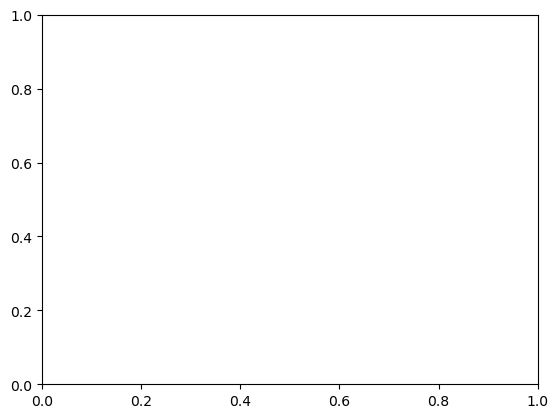

In [11]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
ax = plt.subplot()

for grp, label in [(1, "mutated"), (0, "wild-type")]:
    # 只保留本组中 PFI 相关不缺失的行
    subgroup = meta[meta["top20_mut"] == grp].dropna(subset=["PFI.time", "PFI"])
    kmf.fit(subgroup["PFI.time"], subgroup["PFI"], label=label)
    kmf.plot_survival_function(ax=ax)

plt.title("Top20 genes mutation vs wild-type PFI curve")
plt.show()


In [23]:
from lifelines.statistics import logrank_test

group1 = meta[(meta["top20_mut"]==1)].dropna(subset=["PFI.time","PFI"])
group0 = meta[(meta["top20_mut"]==0)].dropna(subset=["PFI.time","PFI"])
results = logrank_test(
    group1["PFI.time"], group0["PFI.time"],
    event_observed_A=group1["PFI"], event_observed_B=group0["PFI"]
)
print("Log-rank p-value:", results.p_value)


Log-rank p-value: 0.09546052066636158


In [ ]:
import pandas as pd
from lifelines import CoxPHFitter

# 假设 meta 已经加载，且包含 PFI.time, PFI, top20_mut, age_at_initial_pathologic_diagnosis,
# ajcc_pathologic_tumor_stage, histological_grade

# 1) 挑出需要的列并 dropna
df_cox = meta[[
    "PFI.time",
    "PFI",
    "top20_mut",
    "age_at_initial_pathologic_diagnosis",
    "ajcc_pathologic_tumor_stage",
    "histological_grade"
]].dropna()

# 2) 把分期和分级做 one-hot 编码
df_cox = pd.get_dummies(
    df_cox,
    columns=["ajcc_pathologic_tumor_stage", "histological_grade"],
    drop_first=True  # 避免共线性
)

# 3) 检查一下，确保只剩下数值列
print(df_cox.dtypes)

# 4) 拟合 Cox 模型
cph = CoxPHFitter()
cph.fit(df_cox, duration_col="PFI.time", event_col="PFI")
cph.print_summary()


PFI.time                                       float64
PFI                                            float64
top20_mut                                        int64
age_at_initial_pathologic_diagnosis            float64
ajcc_pathologic_tumor_stage_Stage IA              bool
ajcc_pathologic_tumor_stage_Stage IB              bool
ajcc_pathologic_tumor_stage_Stage II              bool
ajcc_pathologic_tumor_stage_Stage IIA             bool
ajcc_pathologic_tumor_stage_Stage IIB             bool
ajcc_pathologic_tumor_stage_Stage III             bool
ajcc_pathologic_tumor_stage_Stage IIIA            bool
ajcc_pathologic_tumor_stage_Stage IIIB            bool
ajcc_pathologic_tumor_stage_Stage IIIC            bool
ajcc_pathologic_tumor_stage_Stage IV              bool
ajcc_pathologic_tumor_stage_[Discrepancy]         bool
ajcc_pathologic_tumor_stage_[Not Available]       bool
histological_grade_G2                             bool
histological_grade_G3                             bool
histologic

/opt/anaconda3/lib/python3.12/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ajcc_pathologic_tumor_stage_[Not Available] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['PFI'].astype(bool)
>>> print(df.loc[events, 'ajcc_pathologic_tumor_stage_[Not Available]'].var())
>>> print(df.loc[~events, 'ajcc_pathologic_tumor_stage_[Not Available]'].var())

A very low variance means that the column ajcc_pathologic_tumor_stage_[Not Available] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm

<lifelines.CoxPHFitter: fitted with 408 total observations, 274 right-censored observations>
             duration col = 'PFI.time'
                event col = 'PFI'
      baseline estimation = breslow
   number of observations = 408
number of events observed = 134
   partial log-likelihood = -692.15
         time fit was run = 2025-04-29 00:07:27 UTC

---
                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                    
top20_mut                                   -0.35      0.71      0.19           -0.71            0.02                0.49                1.02
age_at_initial_pathologic_diagnosis          0.00      1.00      0.01           -0.01            0.02                0.99                1.02
ajcc_pathologic_tumor_stage_Stage IA        13.85  1.04e+06   3651.74        -7143.42         7171.13                0.00                 inf
ajcc_pathologic_tumor_stage_Stage IB        15.28  4.33e+06   3651.74        -7142.00         7172.56                0.00                 inf
ajcc_pathologic_tumor_stage_Stage II        16.08  9.63e+06   3651.74        -7141.20         7173.36                0.00                 inf
ajcc_pathologic_tumor_stage_Stage IIA       15.77  7.06e+06   3651.74        -7141.51         7173.05                0.00                 inf
ajcc_pathologic_tumor_stage_Stage IIB       15.35  4.64e+06   3651.74        -7141.93         7172.63                0.00                 inf
ajcc_pathologic_tumor_stage_Stage III       16.46  1.41e+07   3651.74        -7140.82         7173.74                0.00                 inf
ajcc_pathologic_tumor_stage_Stage IIIA      15.78  7.11e+06   3651.74        -7141.50         7173.05                0.00                 inf
ajcc_pathologic_tumor_stage_Stage IIIB      15.93  8.30e+06   3651.74        -7141.35         7173.21                0.00                 inf
ajcc_pathologic_tumor_stage_Stage IIIC      16.04  9.22e+06   3651.74        -7141.24         7173.31                0.00                 inf
ajcc_pathologic_tumor_stage_Stage IV        16.56  1.55e+07   3651.74        -7140.72         7173.83                0.00                 inf
ajcc_pathologic_tumor_stage_[Discrepancy]   17.03  2.49e+07   3651.74        -7140.25         7174.31                0.00                 inf
ajcc_pathologic_tumor_stage_[Not Available] -0.17      0.85   4293.48        -8415.23         8414.90                0.00                 inf
histological_grade_G2                       -0.72      0.49      0.61           -1.92            0.47                0.15                1.61
histological_grade_G3                       -0.46      0.63      0.60           -1.63            0.72                0.20                2.05
histological_grade_GX                       -0.81      0.45      0.92           -2.61            0.99                0.07                2.70

                                             cmp to     z    p  -log2(p)
covariate                                                               
top20_mut                                      0.00 -1.86 0.06      3.98
age_at_initial_pathologic_diagnosis            0.00  0.20 0.84      0.25
ajcc_pathologic_tumor_stage_Stage IA           0.00  0.00 1.00      0.00
ajcc_pathologic_tumor_stage_Stage IB           0.00  0.00 1.00      0.00
ajcc_pathologic_tumor_stage_Stage II           0.00  0.00 1.00      0.01
ajcc_pathologic_tumor_stage_Stage IIA          0.00  0.00 1.00      0.00
ajcc_pathologic_tumor_stage_Stage IIB          0.00  0.00 1.00      0.00
ajcc_pathologic_tumor_stage_Stage III          0.00  0.00 1.00      0.01
ajcc_pathologic_tumor_stage_Stage IIIA         0.00  0.00 1.00      0.00
ajcc_pathologic_tumor_stage_Stage IIIB         0.00  0.00 1.00      0.01
ajcc_pathologic_tumor_stage_Stage IIIC         0.00  0.00 1.00    

KeyError: ['top20_mut']